## Packages

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [ ]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Loading the data

In [2]:
raw_data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = "1994-01-07", 
                              end = "2019-09-01", interval = "1d", group_by = 'ticker', auto_adjust = True)
print(raw_data)

[*********************100%***********************]  4 of 4 completed
                  ^GSPC                                                       \
                   Open         High          Low        Close        Volume   
Date                                                                           
1994-01-07   467.089996   470.260010   467.029999   469.899994  3.249200e+08   
1994-01-10   469.899994   475.269989   469.549988   475.269989  3.194900e+08   
1994-01-11   475.269989   475.279999   473.269989   474.130005  3.054900e+08   
1994-01-12   474.130005   475.059998   472.140015   474.170013  3.106900e+08   
1994-01-13   474.170013   474.170013   471.799988   472.470001  2.779700e+08   
...                 ...          ...          ...          ...           ...   
2019-08-26  2866.699951  2879.270020  2856.000000  2878.379883  2.859790e+09   
2019-08-27  2893.139893  2898.790039  2860.590088  2869.159912  3.537490e+09   
2019-08-28  2861.280029  2890.030029  2853.050049  

In [3]:
df_comp = raw_data.copy()

In [4]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]
print(df_comp)

                  ^GSPC                                                       \
                   Open         High          Low        Close        Volume   
Date                                                                           
1994-01-07   467.089996   470.260010   467.029999   469.899994  3.249200e+08   
1994-01-10   469.899994   475.269989   469.549988   475.269989  3.194900e+08   
1994-01-11   475.269989   475.279999   473.269989   474.130005  3.054900e+08   
1994-01-12   474.130005   475.059998   472.140015   474.170013  3.106900e+08   
1994-01-13   474.170013   474.170013   471.799988   472.470001  2.779700e+08   
...                 ...          ...          ...          ...           ...   
2019-08-26  2866.699951  2879.270020  2856.000000  2878.379883  2.859790e+09   
2019-08-27  2893.139893  2898.790039  2860.590088  2869.159912  3.537490e+09   
2019-08-28  2861.280029  2890.030029  2853.050049  2887.939941  3.102480e+09   
2019-08-29  2910.370117  2930.500000  29

In [5]:
df_comp = df_comp.iloc[1:]
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')
print(df_comp)

                    spx           dax         ftse        nikkei
                                                                
Date                                                            
1994-01-10   475.269989   2225.000000  3440.600098  18443.439453
1994-01-11   474.130005   2228.100098  3413.800049  18485.250000
1994-01-12   474.170013   2182.060059  3372.000000  18793.880859
1994-01-13   472.470001   2142.370117  3360.000000  18577.259766
1994-01-14   474.910004   2151.050049  3400.600098  18973.699219
...                 ...           ...          ...           ...
2019-08-26  2878.379883  11658.040039  7095.000000  20261.039062
2019-08-27  2869.159912  11730.019531  7089.600098  20456.080078
2019-08-28  2887.939941  11701.019531  7114.700195  20479.419922
2019-08-29  2924.580078  11838.879883  7184.299805  20460.929688
2019-08-30  2926.459961  11939.280273  7207.200195  20704.369141

[6690 rows x 4 columns]


## Creating Returns

In [6]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1).mul(100)
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1).mul(100)
df_comp['ret_dax'] = df_comp.dax.pct_change(1).mul(100)
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1).mul(100)

In [7]:
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1])*100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax[1])*100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100

## Splitting the Data

In [8]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## Fitting a Model

In [9]:
model_ar = ARIMA(df.ftse, order = (1,0,0))
results_ar = model_ar.fit()

## Simple Forecasting

In [10]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2014-07-09,1972.829956,9808.200195,6718.000000,15302.650391,0.464427,-0.304222,0.363568,-0.076789,-193.623849,39.056133,260.939581,-33.873062
2014-07-10,1964.680054,9659.129883,6672.399902,15216.469727,-0.413107,-0.678775,-1.519854,-0.563175,172.228229,87.141370,-1090.828512,-248.427258
2014-07-11,1967.569946,9666.339844,6690.200195,15164.040039,0.147092,0.266775,0.074644,-0.344559,-61.324138,-34.248669,53.573442,-151.991545
2014-07-14,1977.099976,9783.009766,6746.100098,15296.820312,0.484355,0.835549,1.206971,0.875626,-201.932230,-107.268090,866.266436,386.255523
2014-07-15,1973.280029,9719.410156,6710.500000,15395.160156,-0.193210,-0.527714,-0.650103,0.642878,80.550866,67.748084,-466.591262,283.585757


In [11]:
# create variables that will help us change the periods easily instead of typing them up every time
# make sure the start and end dates are business days, otherwise the code will result in an error
start_date = "2014-07-15"
end_date = "2015-01-01"

In [12]:
end_date = "2019-10-23"
df_pred = results_ar.predict(start = start_date, end = end_date)

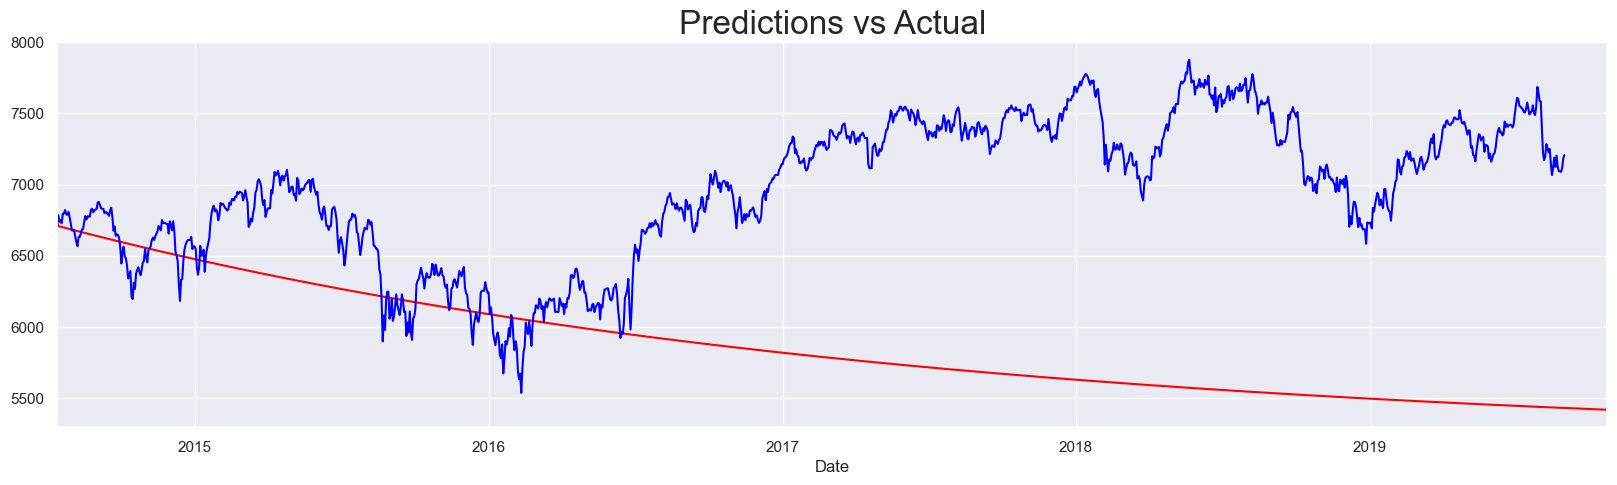

In [13]:
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Using Returns Instead

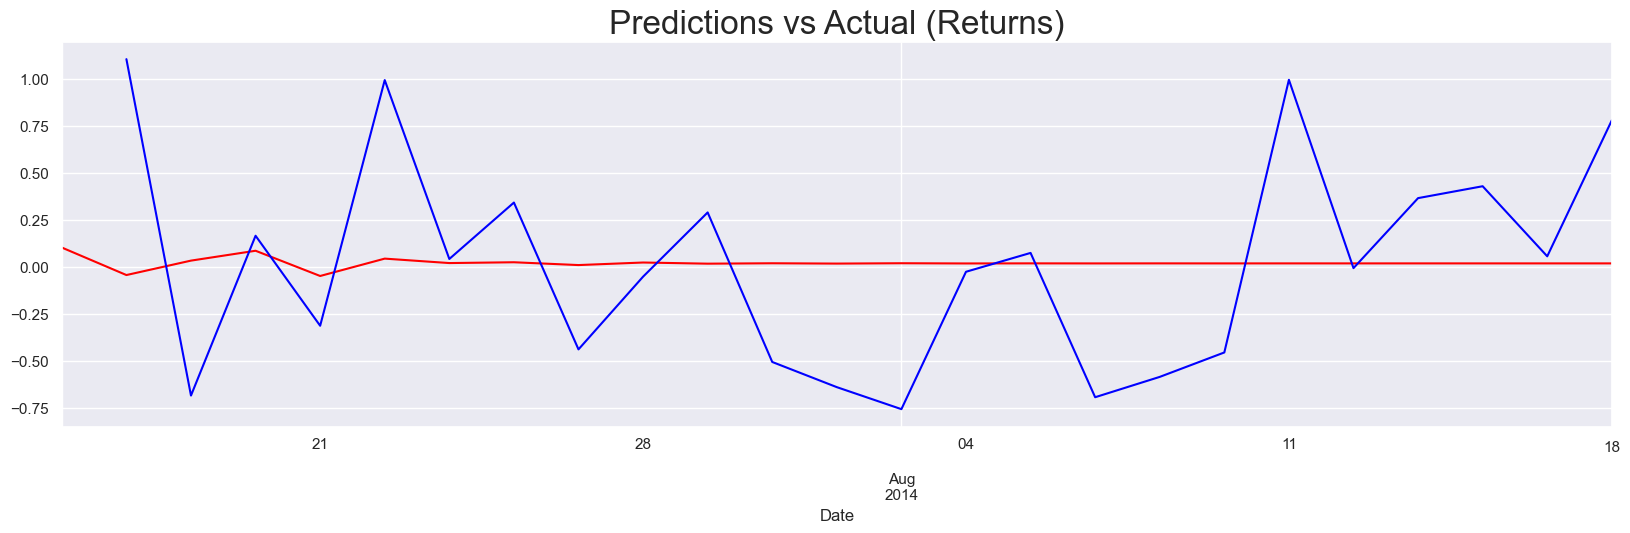

In [14]:
end_date = "2014-08-18"

model_ret_ar = ARIMA(df.ret_ftse[1:], order = (5,0,0))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict(start = start_date, end = end_date) 

df_pred_ar[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [15]:
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5351
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -8306.931
Date:                Thu, 27 Apr 2023   AIC                          16627.862
Time:                        15:30:21   BIC                          16673.958
Sample:                    01-11-1994   HQIC                         16643.963
                         - 07-15-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0192      0.014      1.356      0.175      -0.009       0.047
ar.L1         -0.0214      0.009     -2.459      0.014      -0.038      -0.004
ar.L2         -0.0524      0.008     -6.858      0.000      -0.067      -0.037
ar.L3         -0.0804      0.008    -10.492      0.000      -0.095      -0.065
ar.L4          0.0423      0.008      5.335      0.000       0.027       0.058
ar.L5         -0.0572      0.008     -7.477      0.000      -0.072      -0.042
sigma2         1.3059      0.014     96.686      0.000       1.279       1.332
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              7325.62
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.89   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### MA

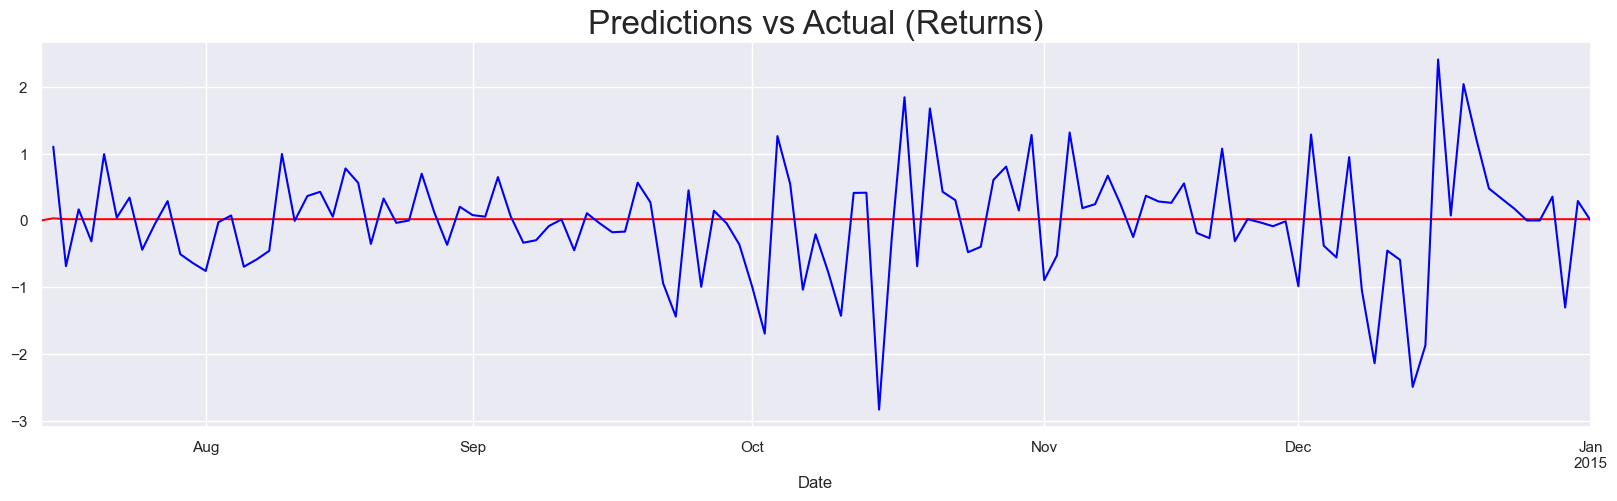

In [16]:
end_date = "2015-01-01"

model_ret_ma = ARIMA(df.ret_ftse[1:], order=(0,0,1))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start = start_date, end = end_date) 

df_pred_ma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [17]:
df_pred_ma.head()

2014-07-15   -0.001408
2014-07-16    0.032249
2014-07-17    0.019113
2014-07-18    0.019113
2014-07-21    0.019113
Freq: B, Name: predicted_mean, dtype: float64

### ARMA

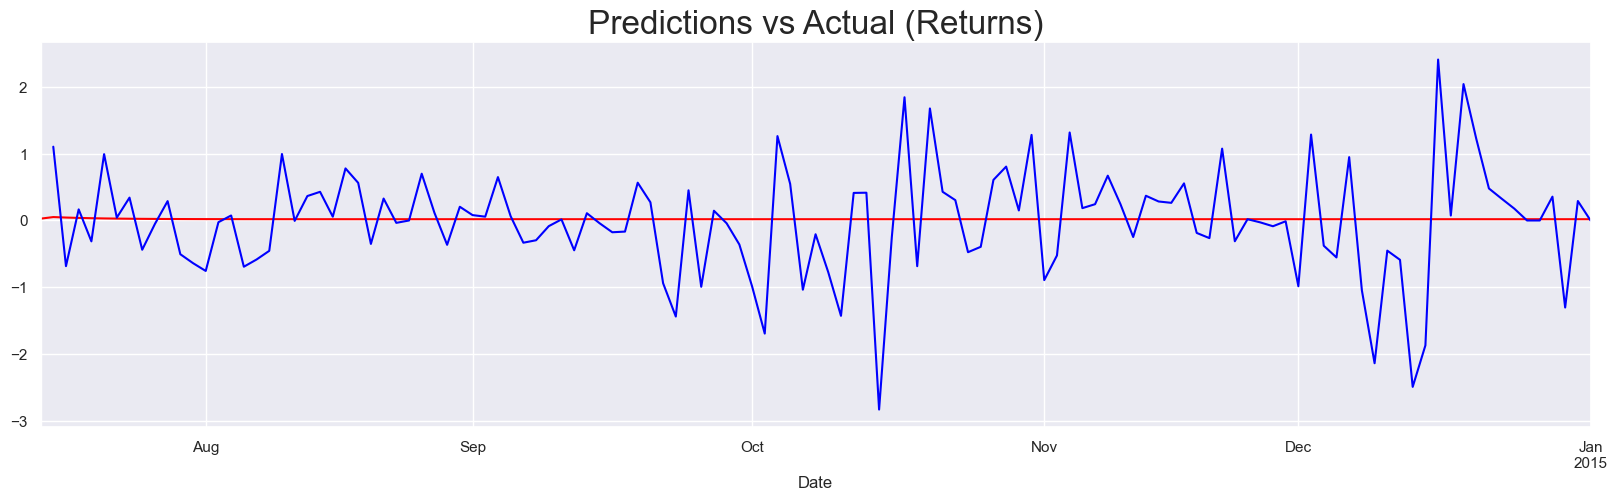

In [18]:
model_ret_arma = ARIMA(df.ret_ftse[1:], order=(1,0,1))
results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict(start = start_date, end = end_date)

df_pred_arma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [19]:
df_pred_arma.head()

2014-07-15    0.027277
2014-07-16    0.051308
2014-07-17    0.044092
2014-07-18    0.038497
2014-07-21    0.034157
Freq: B, Name: predicted_mean, dtype: float64

In [20]:
df_pred_arma.tail()

2014-12-26    0.019164
2014-12-29    0.019164
2014-12-30    0.019164
2014-12-31    0.019164
2015-01-01    0.019164
Freq: B, Name: predicted_mean, dtype: float64

### ARMAX

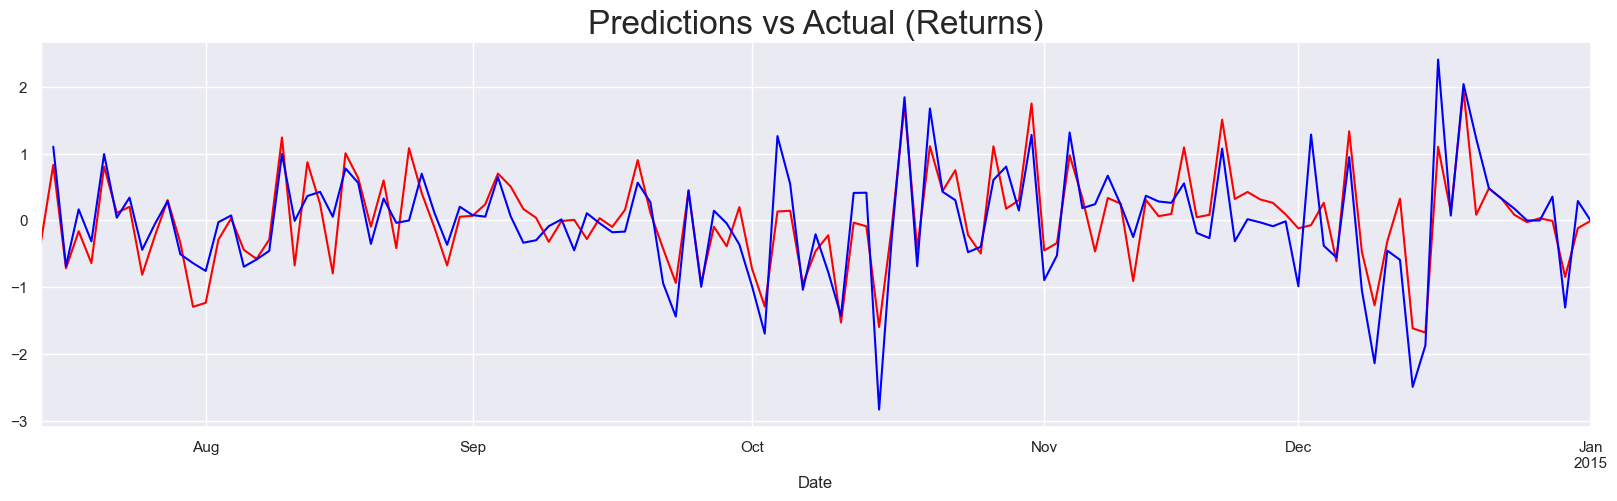

In [21]:
model_ret_armax = ARIMA(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:], order = (1,0,1))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

### SARMA

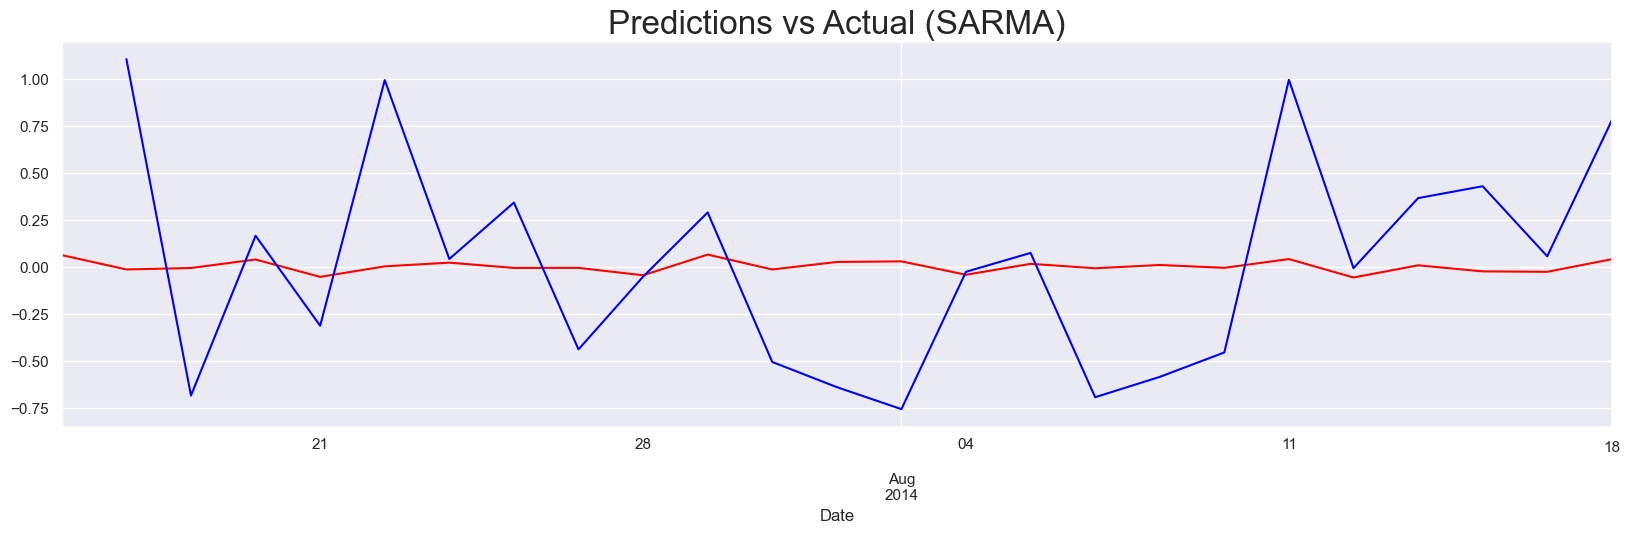

In [22]:
end_date = "2014-08-18"
model_ret_sarma = SARIMAX(df.ret_ftse[1:], order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarma = model_ret_sarma.fit()

df_pred_sarma = results_ret_sarma.predict(start = start_date, end = end_date)

df_pred_sarma[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (SARMA)", size = 24)
plt.show()

### SARIMAX

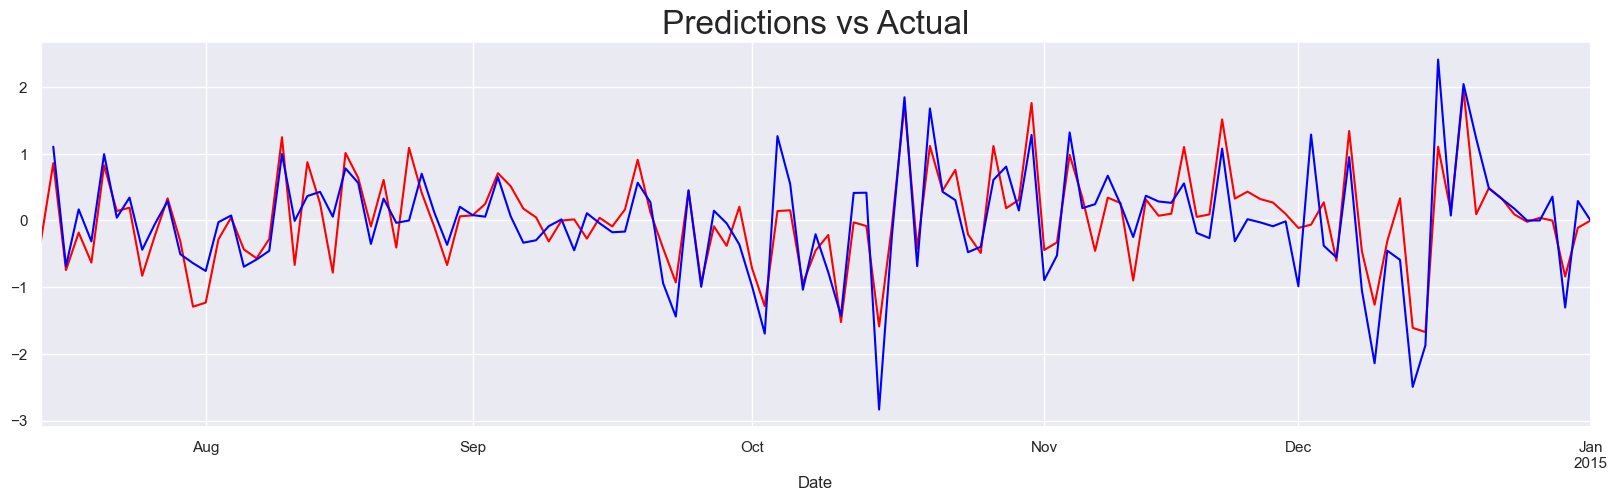

In [23]:
end_date = "2015-01-01"
model_ret_sarimax = SARIMAX(df.ret_ftse[1:], exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:], 
                            order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date, 
                                              exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Auto ARIMA

In [24]:
model_auto = auto_arima(df.ret_ftse[1:], exogenous = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:],
                       m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

In [25]:
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[start_date:end_date]),
                            exogenous = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]),
                            index = df_test[start_date:end_date].index)

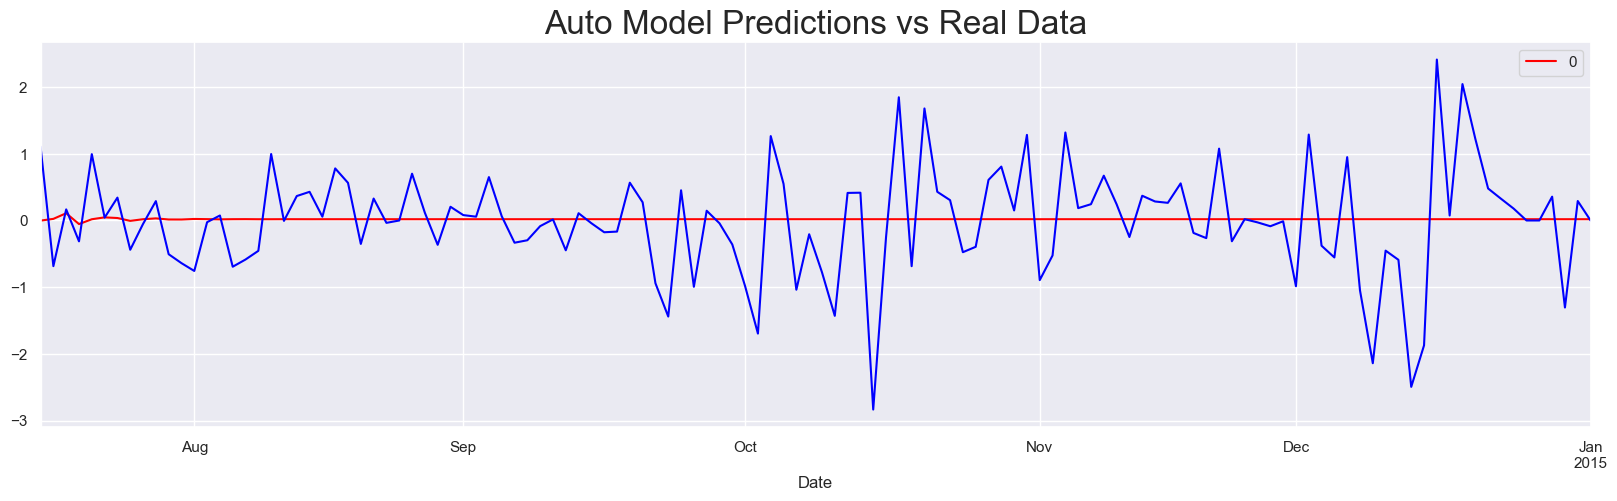

In [26]:
df_auto_pred.plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

### Comparing All the Models (Returns)

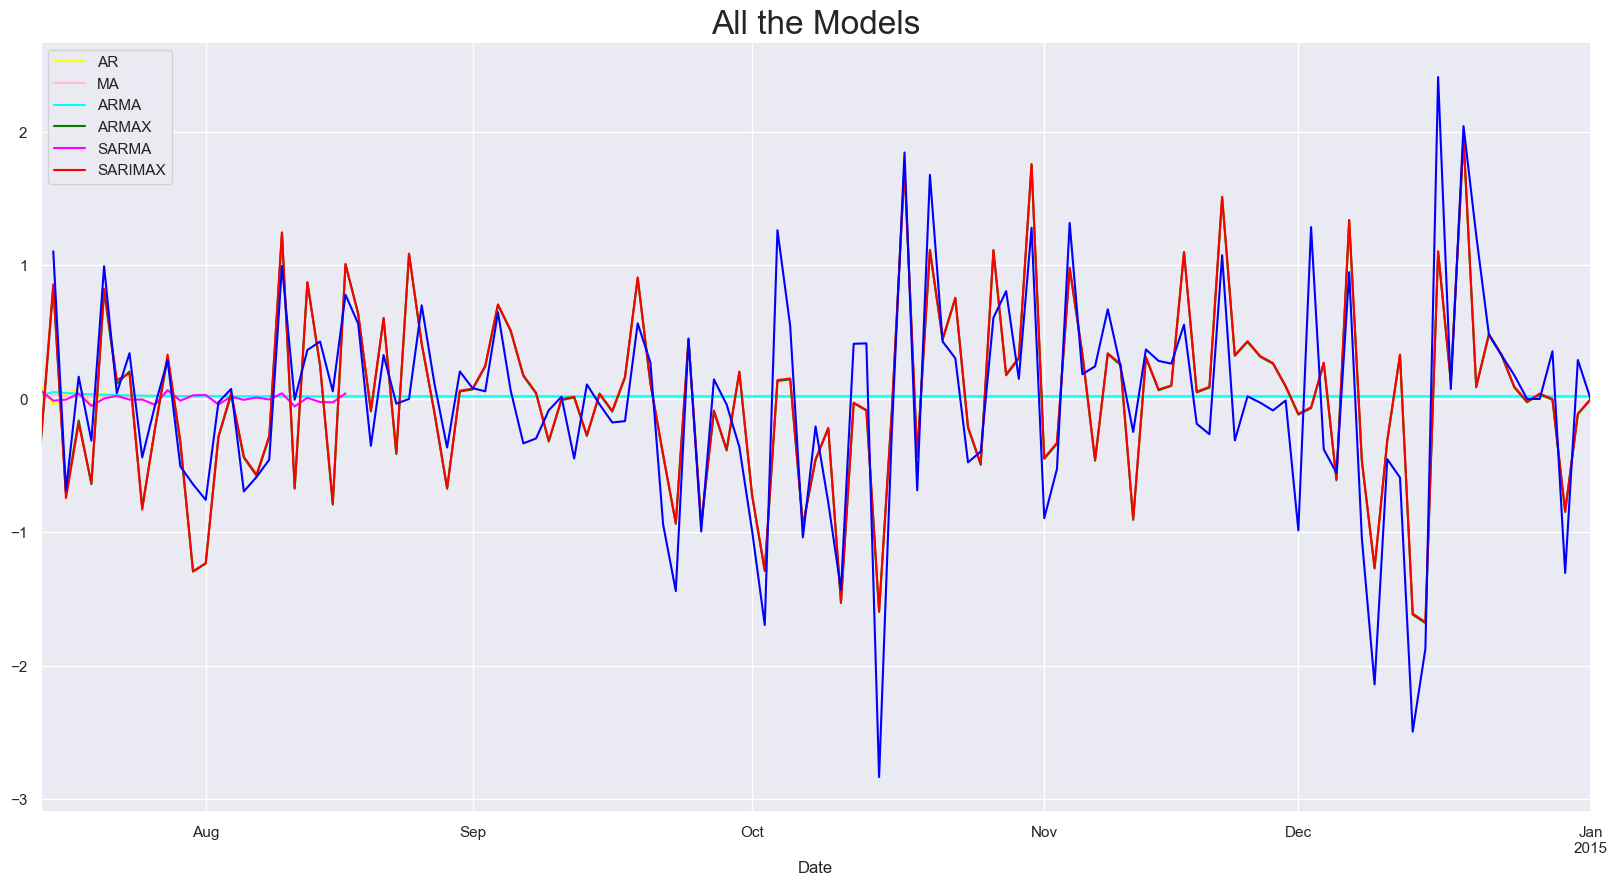

In [27]:
end_date = "2015-01-01"
df_pred_ar[start_date:end_date].plot(figsize = (20,10), color = "yellow")
df_pred_ma[start_date:end_date].plot(color = "pink")
df_pred_arma[start_date:end_date].plot(color = "cyan")
df_pred_armax[start_date:end_date].plot(color = "green")
df_pred_sarma[start_date:end_date].plot(color = "magenta")
df_pred_sarimax[start_date:end_date].plot(color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.legend(['AR','MA','ARMA','ARMAX','SARMA','SARIMAX'])
plt.title("All the Models", size = 24)
plt.show()

### Forecasting Volatility

In [28]:
mod_garch = arch_model(df_comp.ret_ftse[1:], vol = "GARCH", p = 1, q = 1, mean = "constant", dist = "Normal")
res_garch = mod_garch.fit(last_obs = start_date, update_freq = 10)

Iteration:     10,   Func. Count:     65,   Neg. LLF: 7309.738663286329
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7309.738653886656
            Iterations: 12
            Function evaluations: 74
            Gradient evaluations: 12


In [29]:
pred_garch = res_garch.forecast(horizon = 1, align = 'target')

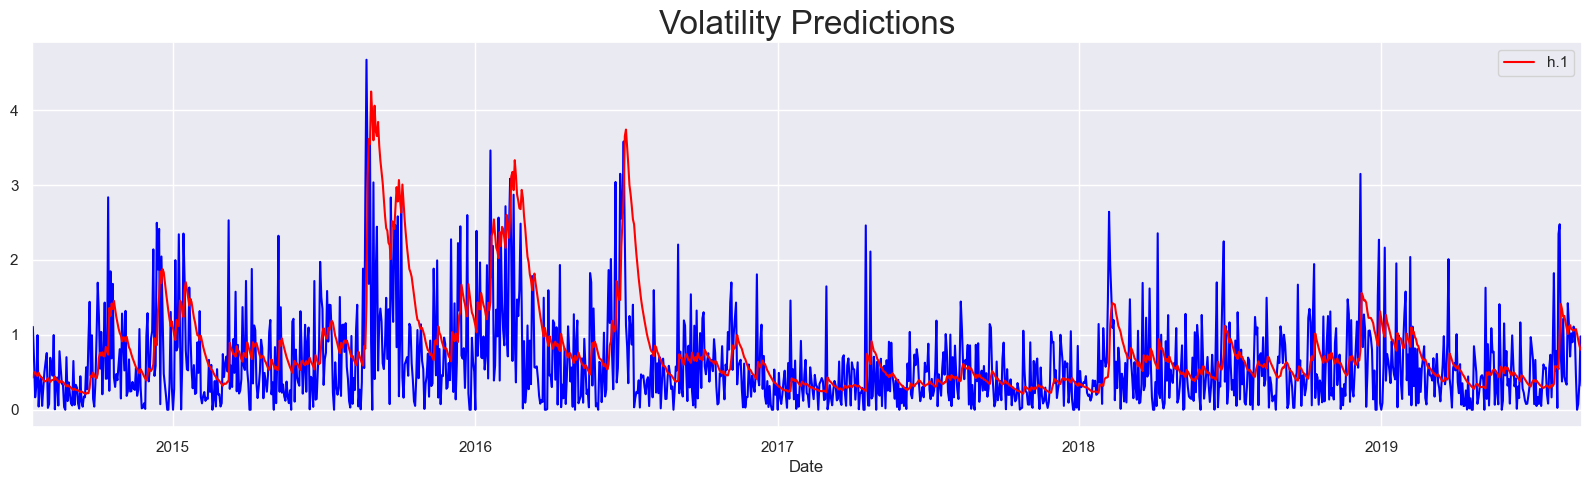

In [30]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.ret_ftse.abs().plot(color = "blue", zorder = 1)
plt.title("Volatility Predictions", size = 24)
plt.show()

In [31]:
pred_garch = res_garch.forecast(horizon = 100, align = 'target')
pred_garch.residual_variance[-1:]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-30,0.810974,0.80513,0.867015,0.940752,1.021296,1.085907,1.07497,1.068781,1.082322,1.091898,...,0.842145,0.843744,0.83523,0.820559,0.832071,0.844172,0.855355,0.86872,0.876198,0.890501


### Multvariate Regression Model

In [32]:
from statsmodels.tsa.api import VAR

In [33]:
df_ret = df[['ret_spx', 'ret_dax', 'ret_ftse', 'ret_nikkei']][1:]

In [34]:
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)
results_var_ret = model_var_ret.fit(ic = 'aic')

In [35]:
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 27, Apr, 2023
Time:                     15:33:14
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.328077
Nobs:                     5346.00    HQIC:                  0.260760
Log likelihood:          -30859.0    FPE:                    1.25185
AIC:                     0.224624    Det(Omega_mle):         1.23237
--------------------------------------------------------------------
Results for equation ret_spx
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.039221         0.016160            2.427           0.015
L1.ret_spx           -0.110815         0.017560           -6.310           0.000
L1.ret_dax            0.064819         0.019027           

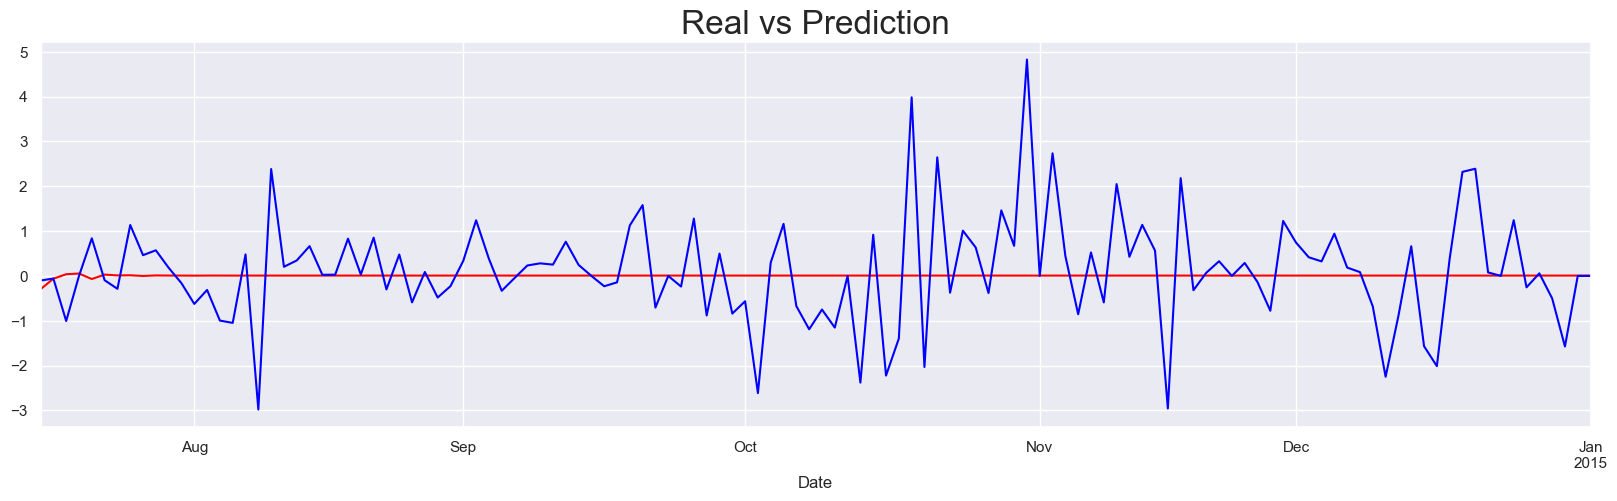

In [36]:
lag_order_ret = results_var_ret.k_ar
var_pred_ret = results_var_ret.forecast(df_ret.values[-lag_order_ret:], len(df_test[start_date:end_date]))

df_ret_pred = pd.DataFrame(data = var_pred_ret, index = df_test[start_date:end_date].index,
                                columns = df_test[start_date:end_date].columns[4:8])

df_ret_pred.ret_nikkei[start_date:end_date].plot(figsize = (20,5), color = "red")

df_test.ret_nikkei[start_date:end_date].plot(color = "blue")
plt.title("Real vs Prediction", size = 24)
plt.show()

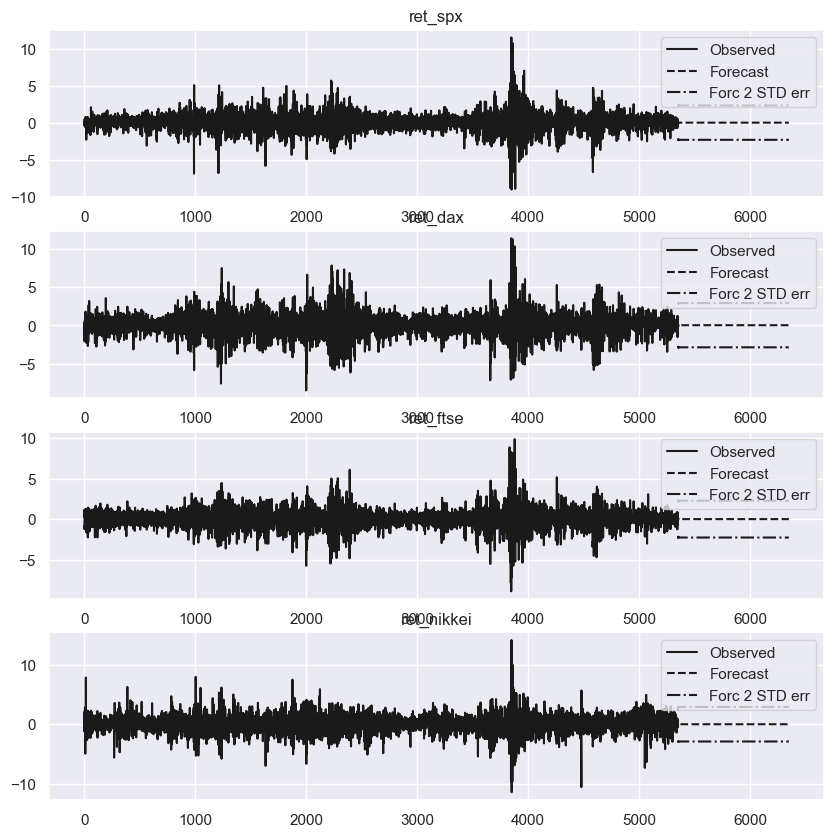

In [37]:
results_var_ret.plot_forecast(1000)
plt.show()